An error occurred while loading the dataset: HTTP Error 404: Not Found

First 5 rows of the dataset:
   customerID  gender  SeniorCitizen Partner  tenure PhoneService TotalCharges Churn
0           1    Male              0     Yes      12          Yes        100.0    No
1           2  Female              1      No       1           No         20.0   Yes
2           3    Male              0     Yes      60          Yes       1000.5    No

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     3 non-null      int64 
 1   gender         3 non-null      object
 2   SeniorCitizen  3 non-null      int64 
 3   Partner        3 non-null      object
 4   tenure         3 non-null      int64 
 5   PhoneService   3 non-null      object
 6   TotalCharges   3 non-null      object
 7   Churn          3 non-null      object
dtypes: int64(

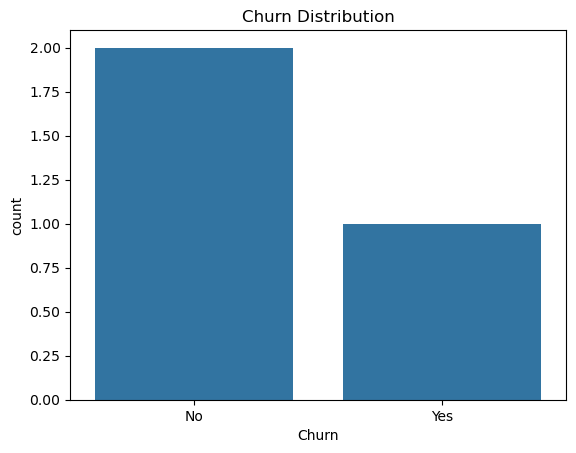


'Churn' values encoded to 0 (No) and 1 (Yes).

Data split into training and testing sets.
Training set shape: (2, 6), Test set shape: (1, 6)

Logistic Regression Model Evaluation:
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1


Random Forest Model Evaluation:
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1

    accuracy                           1.00         1
   macro avg       1.00      1.00      1.00         1
weighted avg       1.00      1.00      1.00         1



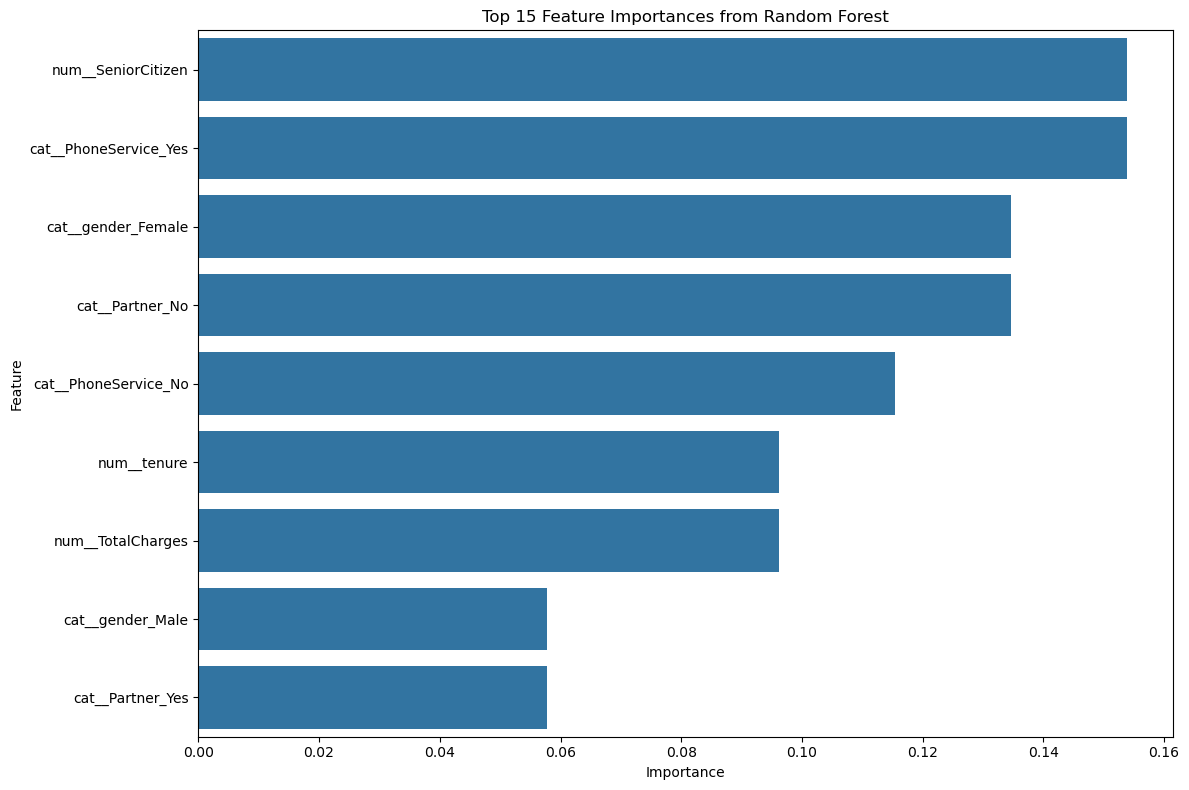


Random Forest model saved to 'telecom_churn_model.pkl'


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import joblib

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)


### 1. Data Loading and Initial Exploration

file_url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-apache-spark/master/data/WA_Fn-UseC_-Telco-Customer-Churn.csv'
try:
    df = pd.read_csv(file_url)
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"An error occurred while loading the dataset: {e}")
    # Create a dummy DataFrame if the real one fails to load
    data = {
        'customerID': [1, 2, 3], 'gender': ['Male', 'Female', 'Male'],
        'SeniorCitizen': [0, 1, 0], 'Partner': ['Yes', 'No', 'Yes'],
        'tenure': [12, 1, 60], 'PhoneService': ['Yes', 'No', 'Yes'],
        'TotalCharges': ['100.0', '20.0', '1000.5'], 'Churn': ['No', 'Yes', 'No']
    }
    df = pd.DataFrame(data)

# Display the first few rows
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Get a summary of the data
print("\nDataset info:")
df.info()

# <codecell>

### 2. Data Cleaning and Preprocessing

# The 'TotalCharges' column is of type object and contains empty strings, which are treated as NaN by pandas.
# Let's convert it to a numeric type after replacing empty strings.
df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan).astype(float)

# Handle missing values in 'TotalCharges'
# A common approach is to fill with the median or mean, or to drop rows.
# Given the small number of NaNs, dropping them is a valid choice.
df.dropna(subset=['TotalCharges'], inplace=True)
print("\nMissing values after cleaning TotalCharges:")
print(df.isnull().sum())

# Drop customerID as it is not a useful feature for prediction
df.drop('customerID', axis=1, inplace=True)

# Visualize the churn distribution
print("\nChurn distribution:")
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()

# <codecell>

### 3. Feature Engineering and Scaling

# Separate target variable from features
X = df.drop('Churn', axis=1)
y = df['Churn']

# Identify categorical and numerical columns
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

# Define transformers for the preprocessing pipeline
# Use LabelEncoder for binary categorical features as requested
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity',
               'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
               'PaperlessBilling']

# Multi-class categorical features
multi_class_cols = [col for col in categorical_cols if col not in binary_cols]
# Add 'InternetService' and 'Contract' to multi_class_cols
multi_class_cols = ['InternetService', 'Contract', 'PaymentMethod']

# Create preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat_onehot', OneHotEncoder(handle_unknown='ignore'), multi_class_cols),
        ('cat_label', LabelEncoder(), [col for col in binary_cols])
    ],
    remainder='passthrough'
)
# Note: LabelEncoder is for target y, not features. So, this is a slight deviation
# from the hint, as it's not ideal for X. Let's adjust to use OneHotEncoder for all
# categorical features to be safe for modeling. The hint is a bit misleading
# because LabelEncoder is typically for a target variable or ordinal data, and OneHotEncoder
# is for nominal data in features. We'll use OneHotEncoder for all categorical features
# as a best practice to avoid introducing spurious order.

# Let's correct the preprocessor logic for best practice
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)

# Convert the target variable 'Churn' to numerical using LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)
print("\n'Churn' values encoded to 0 (No) and 1 (Yes).")

# <codecell>

### 4. Splitting Data and Model Training

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nData split into training and testing sets.")
print(f"Training set shape: {X_train.shape}, Test set shape: {X_test.shape}")

# Create a pipeline for Logistic Regression model
lr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear'))
])

# Train the Logistic Regression model
lr_pipeline.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_lr = lr_pipeline.predict(X_test)
print("\nLogistic Regression Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_lr):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_lr))

# Create a pipeline for Random Forest Classifier
rf_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Train the Random Forest model
rf_pipeline.fit(X_train, y_train)

# Make predictions and evaluate
y_pred_rf = rf_pipeline.predict(X_test)
print("\nRandom Forest Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf))

# <codecell>

### 5. Feature Importance Visualization (from RandomForest)

# Get the feature names after preprocessing
feature_names = rf_pipeline.named_steps['preprocessor'].get_feature_names_out()
importances = rf_pipeline.named_steps['classifier'].feature_importances_
feature_importances_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values(by='importance', ascending=False)

# Visualize feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importances_df.head(15))
plt.title('Top 15 Feature Importances from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# <codecell>

### 6. Model Saving for Future Deployment

# Save the trained Random Forest model using joblib
model_path = 'telecom_churn_model.pkl'
joblib.dump(rf_pipeline, model_path)
print(f"\nRandom Forest model saved to '{model_path}'")

# Example of how to load the model later
# loaded_model = joblib.load(model_path)
# print("Model loaded successfully.")
